In [14]:
# Load packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3, venn3_circles

# 1 Data Import 

In [15]:
# IMPORT raw data from deg (Rstudio)
deg_na = pd.read_csv('comp_anoxia_normoxia.csv', header=0, sep=',').assign(regulation='up', condition='Normoxia to Anoxia').rename(columns={'Unnamed: 0':'transcript_id'})
deg_nr = pd.read_csv('comp_reoxygenation_normoxia.csv', header=0, sep=',').assign(regulation='up', condition='Normoxia to Reoxygenation').rename(columns={'Unnamed: 0':'transcript_id'})
deg_ar = pd.read_csv('comp_anoxia_reoxygenation.csv', header=0, sep=',').assign(regulation='up', condition='Anoxia to Reoxygenation').rename(columns={'Unnamed: 0':'transcript_id'})

# identified lncRNAs
# IMPORT DATA FROM COMMON
common = pd.read_csv('/home/maggy/LncRNA/6_identify_common_lncRNA/common_lncrna_transcript_id.csv')



In [16]:
# drop rows that contains NaN in the padj column 
deg_na = deg_na.dropna(subset=['padj'])
deg_nr = deg_nr.dropna(subset=['padj'])
deg_ar = deg_ar.dropna(subset=['padj'])

# filter for NaN in log2FoldChange column 
deg_na = deg_na.dropna(subset=['log2FoldChange'])
deg_nr = deg_nr.dropna(subset=['log2FoldChange'])
deg_ar = deg_ar.dropna(subset=['log2FoldChange'])

In [17]:
# substitute MSTRG in the dfs to STRG (to get the same format) 
# convert everything in lower case letters
degs = [deg_na, deg_nr, deg_ar]

def process_dfs(dfs):
    """
    Process a list of DataFrames to replace 'MSTRG.' with 'STRG.' in 'transcript_id' column
    and convert 'transcript_id' entries to lowercase.
    
    Parameters:
    dfs (list): List of DataFrames to process
    
    Returns:
    list: List of processed DataFrames
    """
    processed_dfs = []
    for df in dfs:
        df['transcript_id'] = df['transcript_id'].str.replace('MSTRG.', 'STRG.')
        df['transcript_id'] = df['transcript_id'].str.lower()
        processed_dfs.append(df)
    return processed_dfs

process_dfs(degs)   

[                     transcript_id     baseMean  log2FoldChange     lfcSE  \
 0                         strg.1.1  1191.353966        0.422069  0.060668   
 1                         strg.1.2  1188.561338        0.424613  0.060693   
 2                         strg.2.1     1.009087       -1.410735  1.258514   
 3                  ccar_ua01-g3.t2   151.067385       -0.551450  0.107964   
 4       ccar_ua01-g3.t2.1.6676fed8   153.718377       -0.551941  0.107589   
 ...                            ...          ...             ...       ...   
 125823       scaffold_72-g45758.t1     6.212233       -1.303093  0.531051   
 125824       scaffold_72-g45759.t1    23.442440        0.567697  0.233187   
 125825       scaffold_72-g45760.t1    24.303876        0.754413  0.236615   
 125826      scaffold_129-g45565.t1     6.130054       -0.737369  0.587273   
 125827      scaffold_129-g45566.t1     4.193329        0.041591  0.584033   
 
             stat    pvalue      padj regulation           con

In [18]:
# set threshold for fold change 
fold_threshold = 1.3 
p_threshold = 0.05

# 2 Vulcano DEG and lncRNA 

In [19]:
# merge the dataframes and add column with name of comparison
deg = pd.concat([deg_na, deg_nr, deg_ar])

# calculate -log10(padj) for each comparison
deg['-log10p'] = -np.log10(deg['padj'])

# introduce color code 
deg['color'] = 0

# color code for significant genes
deg.loc[abs(deg['log2FoldChange']) >= np.log2(fold_threshold) , 'color'] +=1
deg.loc[deg['padj'] <= p_threshold , 'color'] +=1
deg.loc[deg['transcript_id'].isin(common['transcript_id']), 'color'] +=1

# convert number code into str for Legend labels 
deg.loc[deg['color'] <= 1, 'color'] = 'Not Differentially Expressed'
deg.loc[deg['color'] == 2, 'color'] = 'Differentially Expressed'
deg.loc[deg['color'] == 3, 'color'] = 'Differentially Expressed LncRNA'

/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
# EXPORT FOR TRANSCRIPTION EXPRESSION PLOT 
#filter for lowest padjusted value for differentially expressed 
diff_deg = deg[deg['color'] == 'Differentially Expressed LncRNA']
diff_deg = diff_deg[diff_deg['condition'] == 'Normoxia to Anoxia']
# filter for highest log2FoldChange and lowest log10p value
diff_deg = diff_deg.loc[diff_deg.groupby('transcript_id')['log2FoldChange'].idxmax()]
diff_deg = diff_deg.loc[diff_deg.groupby('transcript_id')['-log10p'].idxmax()]
#export to csv
diff_deg.to_csv('deg_data/ranking_of_most_diff_lncrna.csv', index=False, header=True)


In [7]:
deg['color'].value_counts()

color
Not Differentially Expressed       294907
Differentially Expressed            77753
Differentially Expressed LncRNA      3702
Name: count, dtype: int64

In [8]:
# Vulcano plot
def add_deg_number(data, **kwargs):
    """Add the number of DEGs to each subplot."""
    if np.all(data['color'] == 'Not Differentially Expressed'):
        return 
    elif np.all(data['color'] == 'Differentially Expressed'):
        #(deg_na['log2FoldChange'] >= np.log2(fold_threshold)) & (deg_na['padj'] <= p_threshold )
        pos = sum((data['log2FoldChange'] >= np.log2(fold_threshold)) & (data['padj'] <= p_threshold))
        neg = sum((data['log2FoldChange'] <= -np.log2(fold_threshold)) & (data['padj'] <= p_threshold))
        plt.text(x=-15, y=250, s=fr'$\downarrow${neg}', fontsize=8, ha='center', va='center')
        plt.text(x=+15, y=250, s=fr'$\uparrow${pos}', fontsize=8, ha='center', va='center')
    elif np.all(data['color'] == 'Differentially Expressed LncRNA'):
        poslnc = sum((data['log2FoldChange'] >= np.log2(fold_threshold)) & (data['padj'] <= p_threshold) & (data['transcript_id'].isin(common['transcript_id'])))
        neglnc = sum((data['log2FoldChange'] <= -np.log2(fold_threshold)) & (data['padj'] <= p_threshold) & (data['transcript_id'].isin(common['transcript_id'])))
        plt.text(x=-15, y=200, s=fr'$\downarrow${neglnc}', fontsize=8, ha='center', va='center')
        plt.text(x=+15, y=200, s=fr'$\uparrow${poslnc}', fontsize=8, ha='center', va='center')

/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/maggy/anaconda3/envs/lncrna/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


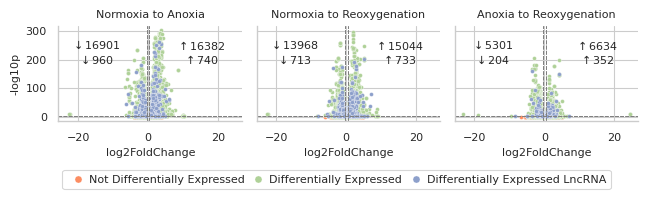

In [9]:
# create subplot for 3 plots 
sns.set_theme(style = 'whitegrid', palette='colorblind', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})

g = sns.FacetGrid(deg, col="condition", hue='color', palette=['#FC8D62', '#AFD198', '#8DA0CB'], height=((4.5)/2.54), aspect=(17/4.5)/3)
g.refline(y=-np.log10(p_threshold), linestyle='--', linewidth=0.7, color='grey')
g.refline(x = np.log2(fold_threshold), linestyle='--', linewidth=0.7, color='grey')
g.refline(x = -np.log2(fold_threshold), linestyle='--', linewidth=0.7, color='grey')
g.map(sns.scatterplot, 'log2FoldChange','-log10p', s=8, rasterized=True)
g.add_legend(title='', fontsize=8, loc='upper center', borderaxespad=0.1, ncol=3, bbox_to_anchor=(.28, 0.02), frameon=True, markerscale=1.8, 
            columnspacing=0.2, scatteryoffsets=[0.5], handletextpad=0.01)
g.set_titles(col_template="{col_name}", fontsize=8)
g.map_dataframe(add_deg_number)
g.tight_layout()

# save as png
g.savefig('vulcano_deg_transcripts.svg', dpi=600)
plt.show()

# 3 Venn plot

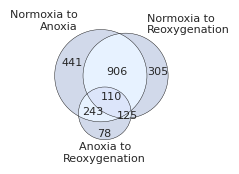

In [26]:
# Filter differentially expressed lncRNAs by condition
deg_na = set(deg[(deg['condition'] == 'Normoxia to Anoxia') & (deg['color'] == 'Differentially Expressed LncRNA')]['transcript_id'])
deg_nr = set(deg[(deg['condition'] == 'Normoxia to Reoxygenation') & (deg['color'] == 'Differentially Expressed LncRNA')]['transcript_id'])
deg_ar = set(deg[(deg['condition'] == 'Anoxia to Reoxygenation') & (deg['color'] == 'Differentially Expressed LncRNA')]['transcript_id'])

# Plotting the Venn Diagram
sns.set_theme(style='whitegrid', context='paper', rc={'axes.labelsize': 8, 'xtick.labelsize': 8, 'ytick.labelsize': 8, 'legend.fontsize': 8, 'legend.title_fontsize': 8})
plt.figure(figsize=(7.5 / 2.54, 4.25 / 2.54))

v = venn3(subsets=[deg_na, deg_nr, deg_ar], set_labels=('Normoxia to\nAnoxia', 'Normoxia to\nReoxygenation', 'Anoxia to\nReoxygenation'), set_colors=('#8DA0CB', "#8DA0CB", "#8DA0CB"))

for text in v.set_labels:
    text.set_fontsize(8)
for text in v.subset_labels:
    if text:  # Check if text is not None
        text.set_fontsize(8)

venn3_circles(subsets=[deg_na, deg_nr, deg_ar], linewidth=0.3, color='black')

# plt.title('Common Differentially Expressed Genes (DEG) between comparisons')
plt.savefig('venn_DEG_lncrna.svg')


# 4 Export data

In [27]:
# export lncRNAs 
# Filter the DataFrame for rows where 'color' is 'Differentially Expressed LncRNA'
filtered_deg = deg[deg['color'] == 'Differentially Expressed LncRNA']

for condition, group in filtered_deg.groupby('condition'):
    filename = f"deg_data/{condition}_lncrna.csv"
    group.to_csv(filename, index=False)

In [28]:
# Define the conditions and directions
conditions = ['Normoxia to Anoxia', 'Normoxia to Reoxygenation', 'Anoxia to Reoxygenation']
directions = ['up', 'down']

# Create a dictionary to store the DataFrames
deg_dict = {}

# Iterate over conditions and directions
for condition in conditions:
    for direction in directions:
        if direction == 'up':
            log_condition = deg['log2FoldChange'] >= np.log2(fold_threshold)
        else:
            log_condition = deg['log2FoldChange'] <= -np.log2(fold_threshold)
            
        # Create the filtered DataFrame
        df = deg.loc[
            (deg['condition'] == condition) &
            (deg['color'].isin(['Differentially Expressed', 'Differentially Expressed LncRNA'])) &
            (deg['padj'] <= p_threshold) &
            log_condition
        ]
        
        # Store it in the dictionary with an appropriate key
        key = f"deg_{condition.replace(' ', '_').lower()}_{direction}"
        deg_dict[key] = df
        
        # Print the length of the DataFrame
        print(f"{key}: {len(df)}")

        # Save to CSV
        df.to_csv(f'deg_data/{key}.csv', index=False)

# Now each filtered DataFrame is accessible through deg_dict.


deg_normoxia_to_anoxia_up: 17122
deg_normoxia_to_anoxia_down: 17861
deg_normoxia_to_reoxygenation_up: 15777
deg_normoxia_to_reoxygenation_down: 14681
deg_anoxia_to_reoxygenation_up: 6986
deg_anoxia_to_reoxygenation_down: 5505


In [30]:
deg[deg['color'] == 'Differentially Expressed LncRNA'].drop_duplicates(subset='transcript_id').to_csv('deg_data/deg_lncrna_transcript_id.csv', index=False)
